## mounting google drive to access dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Spliting dataset into Training, validation, Test sets 

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Set the paths to your face and non-face image folders
face_dir = '/content/drive/MyDrive/FACEDATA/FaceImage3'
non_face_dir = '/content/drive/MyDrive/FACEDATA/NonFaceImage2'

# Create lists to store image file paths
face_images = [os.path.join(face_dir, filename) for filename in os.listdir(face_dir)]
non_face_images = [os.path.join(non_face_dir, filename) for filename in os.listdir(non_face_dir)]

# Define the number of samples you want for each set
total_samples = 2500
train_ratio = 0.7  # 70% for training
valid_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Split the data into training, validation, and test sets
train_faces, test_faces = train_test_split(face_images, test_size=1 - train_ratio, random_state=42)
valid_faces, test_faces = train_test_split(test_faces, test_size=test_ratio / (test_ratio + valid_ratio), random_state=42)

train_non_faces, test_non_faces = train_test_split(non_face_images, test_size=1 - train_ratio, random_state=42)
valid_non_faces, test_non_faces = train_test_split(test_non_faces, test_size=test_ratio / (test_ratio + valid_ratio), random_state=42)

# Combine the face and non-face samples for each set
train_data = train_faces + train_non_faces
valid_data = valid_faces + valid_non_faces
test_data = test_faces + test_non_faces

# Shuffle the data to randomize the order
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

# Now you have three lists: train_data, valid_data, and test_data, containing file paths of your images for each set.


# Displaying some images from each splitted dataset

In [ ]:
# Display the first few images from each dataset
def display_images(image_paths, num_images=5):
    for i in range(num_images):
        img = Image.open(image_paths[i])
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.show()

Training Data:


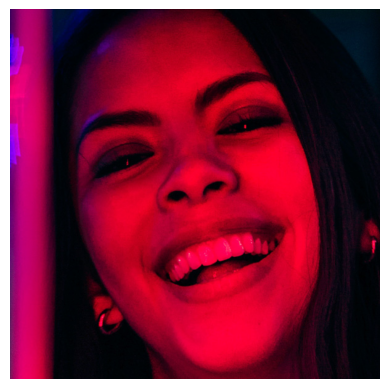

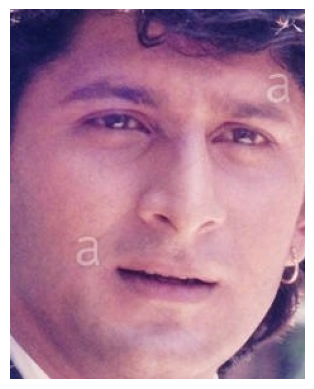

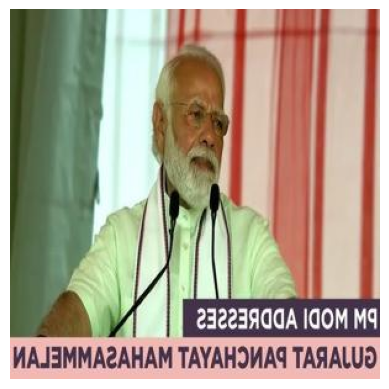

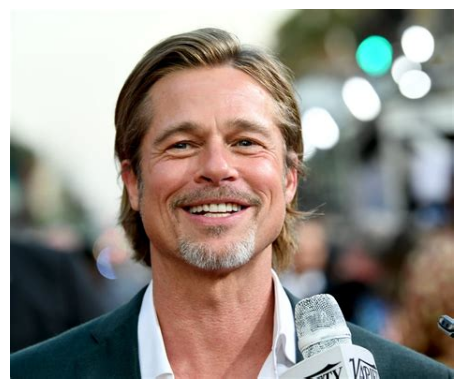

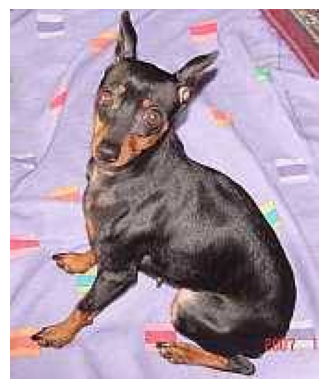


Validation Data:


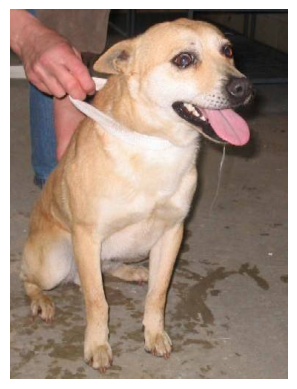

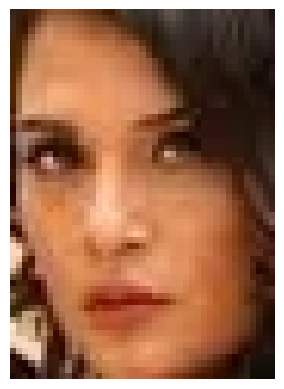

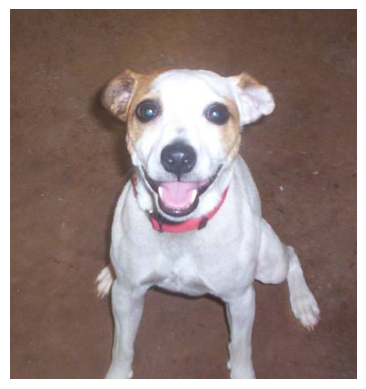

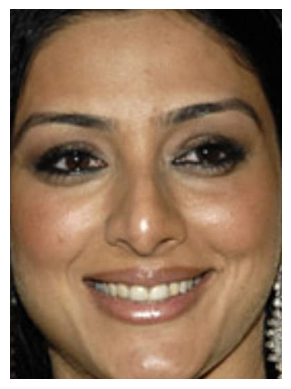

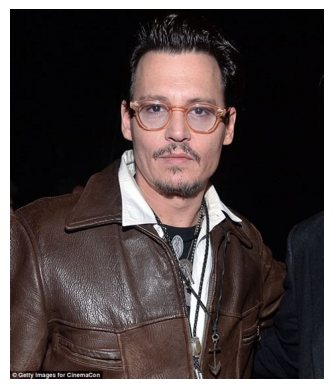


Test Data:


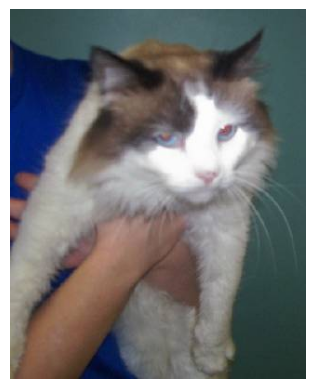

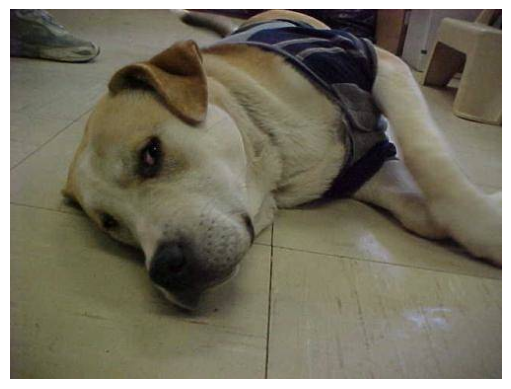

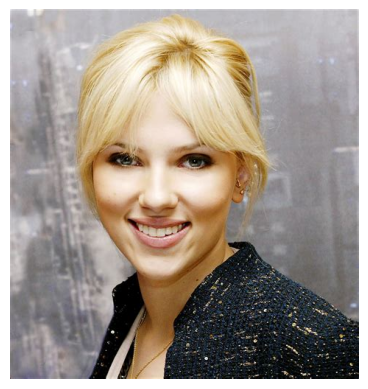

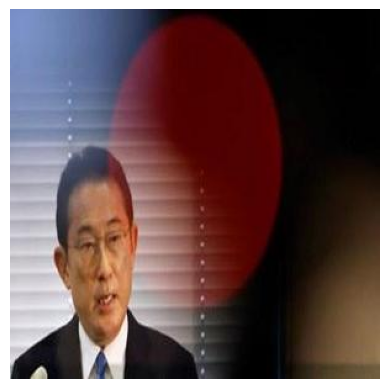

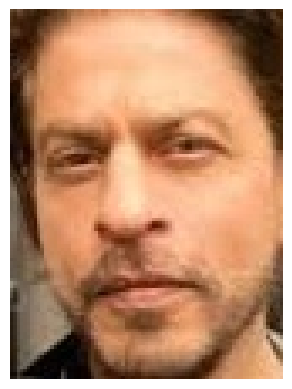

In [ ]:
print("Training Data:")
display_images(train_data[:5])

print("\nValidation Data:")
display_images(valid_data[:5])

print("\nTest Data:")
display_images(test_data[:5])


In [ ]:
# Print the first few file paths from each dataset for verification
print("First few training data samples:")
print(train_data)

print("\nFirst few validation data samples:")
print(valid_data)

print("\nFirst few test data samples:")
print(test_data)


First few training data samples:
['/content/drive/MyDrive/FACEDATA/FaceImage3/real_00696.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/1b5a122519.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/NarendraModi510_c.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/015_82889ec9.jpg', '/content/drive/MyDrive/FACEDATA/NonFaceImage2/dog.1774.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/081_12fb31ec.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/ScottMorrison57_c.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/ScottMorrison139_c.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/real_00431.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/real_00131.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/JoeBiden333_c.jpg', '/content/drive/MyDrive/FACEDATA/NonFaceImage2/dog.1322.jpg', '/content/drive/MyDrive/FACEDATA/NonFaceImage2/dog185.jpg', '/content/drive/MyDrive/FACEDATA/FaceImage3/ScottMorrison264.jpg', '/content/drive/MyDrive/FACEDATA/NonFaceImage2/cat.948.jpg', '/content/drive

# training the neural network using Hinge loss function and Cross-Entropy loss function with 2 hidden layers

In [ ]:
# Define a function to load and preprocess images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (64, 64))  # Resize images to a consistent size
                img = img / 500.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(1 if 'face' in subdir else 0) # assign 1 to faces and 0 to non-faces

    return np.array(images), np.array(labels)

# Define minimum samples for each class
# min_samples_per_class = {'face': 7500, 'non-face': 2500}


# Load face and non-face images (update the paths)
face_images, face_labels = load_images_from_directory('/content/drive/MyDrive/FACEDATA/FaceImage2')
non_face_images, non_face_labels = load_images_from_directory('/content/drive/MyDrive/FACEDATA/NonFaceImage2')

# # Ensure a minimum of 2500 samples for each class
# min_samples_per_class = 2000

# Shuffle and select the minimum samples for each class
np.random.seed(42)  # For reproducibility
np.random.shuffle(face_images)
np.random.shuffle(non_face_images)
face_images = face_images[:]
non_face_images = non_face_images[:]






# Create labels for the selected samples
face_labels = np.ones(len(face_images), dtype=int)
non_face_labels = np.zeros(len(non_face_images), dtype=int)


# Concatenate the data and labels
images = np.concatenate([face_images, non_face_images], axis=0)
labels = np.concatenate([face_labels, non_face_labels], axis=0)





# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)



# Define the neural network model with hinge loss
model_hinge = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='linear')  # Output layer for hinge loss
])

# Compile the model with hinge loss and hinge metric
model_hinge.compile(optimizer='adam',
                    loss='hinge',
                    metrics=['accuracy'])

# Define the neural network model with cross-entropy loss
model_cross_entropy = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Output layer for cross-entropy loss
])

# Compile the model with cross-entropy loss
model_cross_entropy.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])




# Train the models
epochs = 5

# Train the model with hinge loss
history_hinge = model_hinge.fit(X_train, y_train, epochs=epochs,
                                validation_data=(X_val, y_val), verbose=2)
np.save('history_hinge.npy', history_hinge)

# Train the model with cross-entropy loss
history_cross_entropy = model_cross_entropy.fit(X_train, y_train, epochs=epochs,
                                                validation_data=(X_val, y_val), verbose=2)
np.save('history_cross_entropy.npy', history_cross_entropy)

# Evaluate both models on the test set
test_loss_hinge, test_accuracy_hinge = model_hinge.evaluate(X_test, y_test)
test_loss_cross_entropy, test_accuracy_cross_entropy = model_cross_entropy.evaluate(X_test, y_test)





Epoch 1/5
125/125 - 41s - loss: 0.4996 - accuracy: 0.7890 - val_loss: 0.3232 - val_accuracy: 0.8709 - 41s/epoch - 325ms/step
Epoch 2/5
125/125 - 38s - loss: 0.2900 - accuracy: 0.8841 - val_loss: 0.2431 - val_accuracy: 0.8908 - 38s/epoch - 305ms/step
Epoch 3/5
125/125 - 37s - loss: 0.2318 - accuracy: 0.9037 - val_loss: 0.1938 - val_accuracy: 0.9155 - 37s/epoch - 295ms/step
Epoch 4/5
125/125 - 38s - loss: 0.1683 - accuracy: 0.9351 - val_loss: 0.1757 - val_accuracy: 0.9237 - 38s/epoch - 304ms/step
Epoch 5/5
125/125 - 40s - loss: 0.1507 - accuracy: 0.9401 - val_loss: 0.1880 - val_accuracy: 0.9178 - 40s/epoch - 317ms/step
Epoch 1/5
125/125 - 43s - loss: 0.4337 - accuracy: 0.7948 - val_loss: 0.4680 - val_accuracy: 0.7946 - 43s/epoch - 343ms/step
Epoch 2/5
125/125 - 37s - loss: 0.3115 - accuracy: 0.8778 - val_loss: 0.3988 - val_accuracy: 0.8404 - 37s/epoch - 298ms/step
Epoch 3/5
125/125 - 40s - loss: 0.2572 - accuracy: 0.8969 - val_loss: 0.2214 - val_accuracy: 0.9096 - 40s/epoch - 320ms/step


In [ ]:
# Print test accuracy for both models
print(f'Test Accuracy (Hinge Loss): {test_accuracy_hinge}')
print(f'Test Accuracy (Cross-Entropy Loss): {test_accuracy_cross_entropy}')

# Print test loss for both models
print(f'Test Loss (Hinge Loss): {test_loss_hinge}')
print(f'Test Loss (Cross-Entropy Loss): {test_loss_cross_entropy}')

Test Accuracy (Hinge Loss): 0.9308323860168457
Test Accuracy (Cross-Entropy Loss): 0.9167643785476685
Test Loss (Hinge Loss): 0.17385028302669525
Test Loss (Cross-Entropy Loss): 0.204978346824646


# Plotting Training, Validation and Test loss values across epochs for both models

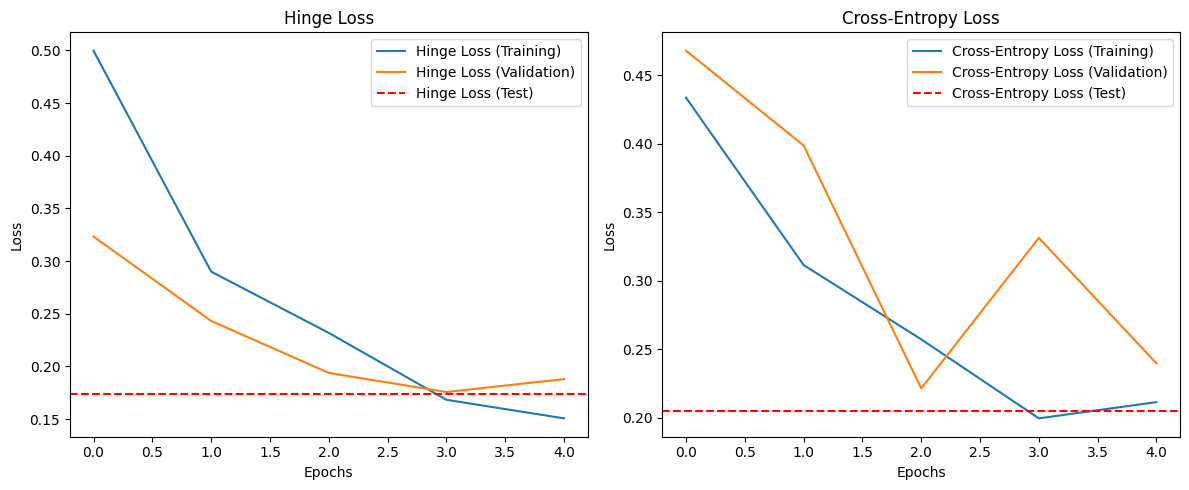

In [ ]:
# Plot the training and validation loss for both models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hinge.history['loss'], label='Hinge Loss (Training)')
plt.plot(history_hinge.history['val_loss'], label='Hinge Loss (Validation)')
plt.axhline(y=test_loss_hinge, color='r', linestyle='--', label='Hinge Loss (Test)')
# plt.plot(len(history_hinge.history['loss'])-1, test_loss_hinge, label='Hinge Loss (Test)', linestyle='dashed')
# plt.plot(history_hinge.history['test_loss'], label='Hinge Loss (Test)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Hinge Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cross_entropy.history['loss'], label='Cross-Entropy Loss (Training)')
plt.plot(history_cross_entropy.history['val_loss'], label='Cross-Entropy Loss (Validation)')
plt.axhline(y=test_loss_cross_entropy, color='r', linestyle='--', label='Cross-Entropy Loss (Test)')
# plt.plot(len(history_cross_entropy.history['loss'])-1, test_loss_cross_entropy, label='Cross-Entropy Loss (Test)', linestyle='dashed')
# plt.plot(history_cross_entropy.history['test_loss'], label='Cross-Entropy Loss (Test)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predicting images for both models to know that they are predicting images correctly or not

In [ ]:
import cv2
import numpy as np

def predict_images(model_hinge, model_cross_entropy, image_paths, threshold=0.5):
    predictions_hinge = []
    predictions_cross_entropy = []

    for image_path in image_paths:
        # Load and preprocess the image
        verification_image = cv2.imread(image_path)
        verification_image = cv2.resize(verification_image, (64, 64))
        verification_image = verification_image / 255.0
        verification_image = np.expand_dims(verification_image, axis=0)  # Add batch dimension

        # Use the hinge loss model to make predictions
        hinge_prediction = model_hinge.predict(verification_image)[:, 1]

        # Use the cross-entropy loss model to make predictions
        cross_entropy_prediction = model_cross_entropy.predict(verification_image)[:, 1]

        # Make binary decisions based on the threshold
        hinge_decision = 1 if hinge_prediction > threshold else 0
        cross_entropy_decision = 1 if cross_entropy_prediction > threshold else 0

        # Append the decisions to the predictions list
        predictions_hinge.append(hinge_decision)
        predictions_cross_entropy.append(cross_entropy_decision)

    return predictions_hinge, predictions_cross_entropy

# Specify the directory containing the image files
image_directory = '/content/drive/MyDrive/FACEDATA/FacePrediction'  # Replace with the path to your directory

# Get a list of all image file paths in the directory
image_paths = []
for root, _, files in os.walk(image_directory):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_paths.append(os.path.join(root, file))

# Set the threshold for binary decisions
threshold = 0.9  # Adjust as needed

# Make predictions for the list of images
predictions_hinge, predictions_cross_entropy = predict_images(model_hinge, model_cross_entropy, image_paths, threshold)

# Print the predictions
for i, image_path in enumerate(image_paths):
    print(f'Image: {image_path}')
    print(f'Hinge Loss Model Decision: {"Face" if predictions_hinge[i] == 1 else "Non-Face"}')
    print(f'Cross-Entropy Loss Model Decision: {"Face" if predictions_cross_entropy[i] == 1 else "Non-Face"}')
    print()



1/1 [==============================] - 0s 24ms/step
Image: /content/drive/MyDrive/FACEDATA/FacePrediction/chair38.jpg
Hinge Loss Model Decision: Non-Face
Cross-Entropy Loss Model Decision: Non-Face

Image: /content/drive/MyDrive/FACEDATA/FacePrediction/gates1.jpg
Hinge Loss Model Decision: Face
Cross-Entropy Loss Model Decision: Face

Image: /content/drive/MyDrive/FACEDATA/FacePrediction/musk1.jpg
Hinge Loss Model Decision: Face
Cross-Entropy Loss Model Decision: Face

Image: /content/drive/MyDrive/FACEDATA/FacePrediction/musk0.jpg
Hinge Loss Model Decision: Face
Cross-Entropy Loss Model Decision: Face

Image: /content/drive/MyDrive/FACEDATA/FacePrediction/jack1.jpg
Hinge Loss Model Decision: Face
Cross-Entropy Loss Model Decision: Face

Image: /content/drive/MyDrive/FACEDATA/FacePrediction/donald trump speech102.jpg
Hinge Loss Model Decision: Face
Cross-Entropy Loss Model Decision: Face

Image: /content/drive/MyDrive/FACEDATA/FacePrediction/donald trump speech101.jpg
Hinge Loss Model 

# Checking Receptive field size of any choosen neuron in each layer

In [ ]:
from tensorflow.keras.models import load_model

# Load your pre-trained models for hinge and cross-entropy losses
model_hinge.save('model_hinge.h5')
model_cross_entropy.save('model_cross_entropy.h5')

# Specify the neuron index (0 for the first neuron in each layer)
neuron_index = 0

# Function to calculate the receptive field for a specific neuron in a layer
def receptive_field(model_hinge, layer_index, neuron_index):
    # Get the layer by index
    layer = model_hinge.layers[layer_index]

    # Initialize receptive field size to 1
    rf_size = 1

    # Iterate through the layers from the specified layer index to the beginning
    for i in range(layer_index, -1, -1):
        layer = model_hinge.layers[i]

        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            # Calculate receptive field size for this layer
            rf_size += (layer.kernel_size[0] - 1) * layer.strides[0]

    return rf_size

# Iterate through all layers and print their receptive field sizes for the specified neuron
for i, layer in enumerate(model_hinge.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        # Calculate receptive field size for the layer and neuron in the hinge loss model
        rf_size_hinge = receptive_field(model_hinge, i, neuron_index)

        # Print the receptive field size for the layer and neuron in both models
        print(f"Layer {i}: Receptive Field Size for Neuron {neuron_index} (Hinge Loss): {rf_size_hinge}")


# Function to calculate the receptive field for a specific neuron in a layer
def receptive_field(model_cross_entropy, layer_index, neuron_index):
    # Get the layer by index
    layer = model_cross_entropy.layers[layer_index]

    # Initialize receptive field size to 1
    rf_size = 1

    # Iterate through the layers from the specified layer index to the beginning
    for i in range(layer_index, -1, -1):
        layer = model_cross_entropy.layers[i]

        # Check if the layer is a convolutional layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            # Calculate receptive field size for this layer
            rf_size += (layer.kernel_size[0] - 1) * layer.strides[0]

    return rf_size

# Iterate through all layers and print their receptive field sizes for the specified neuron
for i, layer in enumerate(model_cross_entropy.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):

        # Calculate receptive field size for the layer and neuron in the cross-entropy loss model
        rf_size_cross_entropy = receptive_field(model_cross_entropy, i, neuron_index)

        # Print the receptive field size for the layer and neuron in both models
        print(f"Layer {i}: Receptive Field Size for Neuron {neuron_index} (Cross-Entropy Loss): {rf_size_cross_entropy}")


Layer 0: Receptive Field Size for Neuron 0 (Hinge Loss): 5
Layer 2: Receptive Field Size for Neuron 0 (Hinge Loss): 9
Layer 0: Receptive Field Size for Neuron 0 (Cross-Entropy Loss): 5
Layer 2: Receptive Field Size for Neuron 0 (Cross-Entropy Loss): 9


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Adding regularisation and tuning hyperparameter to control emphasis on the mis-classification term

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load your pre-trained models and their corresponding histories
model_hinge = tf.keras.models.load_model('model_hinge.h5')
model_cross_entropy = tf.keras.models.load_model('model_cross_entropy.h5')

history_hinge = np.load('history_hinge.npy', allow_pickle=True).item()
history_cross_entropy = np.load('history_cross_entropy.npy', allow_pickle=True).item()

# Define the regularization strengths and emphasis factor
reg_strengths = [0.001, 0.01]
emphasis_factors = [0.5, 1.0]  # Adjust the emphasis factor as needed

# Load your data (X_train, y_train, X_val, y_val, X_test, y_test) here
# ...

# Define a function to create and fine-tune the model
def fine_tune_model(base_model, reg_strength, emphasis_factor, loss_function):
    model = Sequential()

    # Add layers from the pretrained model (up to the last non-output layer)
    for layer in base_model.layers[:-1]:
        model.add(layer)

    # Add a new dropout layer with emphasis
    model.add(Dropout(rate=reg_strength * emphasis_factor))

    # Add a new dense layer with L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_strength)))

    # Add the output layer for the specified loss function
    model.add(Dense(2, activation='linear'))  # Output layer

    # Compile the model with the specified loss function
    model.compile(optimizer=Adam(), loss=loss_function, metrics=['accuracy'])

    return model

# Initialize variables to keep track of the best model and its performance
best_model = None
best_accuracy = 0.0
best_reg_strength = 0.0
best_emphasis = 0.0
best_loss_function = ''

# Initialize lists to store training and validation loss, and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to store final training and validation loss for the best hyperparameters
final_train_loss = None
final_val_loss = None

# Loop over regularization strengths, emphasis factors, and loss functions
loss_functions = ['hinge', 'binary_crossentropy']
for reg_strength in reg_strengths:
    for emphasis in emphasis_factors:
        for loss_function in loss_functions:
            if loss_function == 'hinge':
                history = history_hinge
                base_model = model_hinge
            else:
                history = history_cross_entropy
                base_model = model_cross_entropy

            # Create and fine-tune the model
            fine_tuned_model = fine_tune_model(base_model, reg_strength, emphasis, loss_function)

            # Train the fine-tuned model using the training data
            history_final = fine_tuned_model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), verbose=2)

            # Evaluate the fine-tuned model on the validation set
            val_loss, val_accuracy = fine_tuned_model.evaluate(X_val, y_val)

            # Update best model and hyperparameters if the current model is better
            if val_accuracy > best_accuracy:
                best_model = fine_tuned_model
                best_accuracy = val_accuracy
                best_reg_strength = reg_strength
                best_emphasis = emphasis
                best_loss_function = loss_function
                final_train_loss = history_final.history['loss'][-1]
                final_val_loss = history_final.history['val_loss'][-1]


            # Store training and validation loss and accuracy
            train_losses.append(history_final.history['loss'])
            val_losses.append(history_final.history['val_loss'])
            train_accuracies.append(history_final.history['accuracy'])
            val_accuracies.append(history_final.history['val_accuracy'])

            print(f'Regularization Strength: {reg_strength}, Emphasis Factor: {emphasis}, Loss Function: {loss_function}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the best model on the test set
final_test_loss, final_test_accuracy = best_model.evaluate(X_test, y_test)



# Print the best hyperparameters and final test accuracy
print(f'Best Regularization Strength: {best_reg_strength}, Best Emphasis Factor: {best_emphasis}, Best Loss Function: {best_loss_function}')
print(f'Final Test Accuracy: {final_test_accuracy * 100:.2f}%')

# Print the final training and validation loss for the best hyperparameters
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')



Epoch 1/5
125/125 - 41s - loss: 0.2391 - accuracy: 0.9321 - val_loss: 0.2243 - val_accuracy: 0.9237 - 41s/epoch - 329ms/step
Epoch 2/5
125/125 - 39s - loss: 0.1239 - accuracy: 0.9598 - val_loss: 0.1714 - val_accuracy: 0.9378 - 39s/epoch - 310ms/step
Epoch 3/5
125/125 - 39s - loss: 0.1156 - accuracy: 0.9618 - val_loss: 0.1519 - val_accuracy: 0.9437 - 39s/epoch - 309ms/step
Epoch 4/5
125/125 - 36s - loss: 0.1102 - accuracy: 0.9643 - val_loss: 0.1635 - val_accuracy: 0.9437 - 36s/epoch - 291ms/step
Epoch 5/5
125/125 - 38s - loss: 0.0782 - accuracy: 0.9781 - val_loss: 0.1501 - val_accuracy: 0.9484 - 38s/epoch - 307ms/step
27/27 [==============================] - 2s 65ms/step - loss: 0.1501 - accuracy: 0.9484
Regularization Strength: 0.001, Emphasis Factor: 0.5, Loss Function: hinge
Validation Loss: 0.1501, Validation Accuracy: 94.84%
Epoch 1/5
125/125 - 40s - loss: 0.9581 - accuracy: 0.8677 - val_loss: 0.5430 - val_accuracy: 0.8779 - 40s/epoch - 321ms/step
Epoch 2/5
125/125 - 35s - loss: 0.

In [ ]:
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

Final Test Loss: 0.2541085183620453
Final Test Accuracy: 0.93552166223526


# Plotting Training, Validation and Test loss for best regularisation, best hyperparameter and best loss function

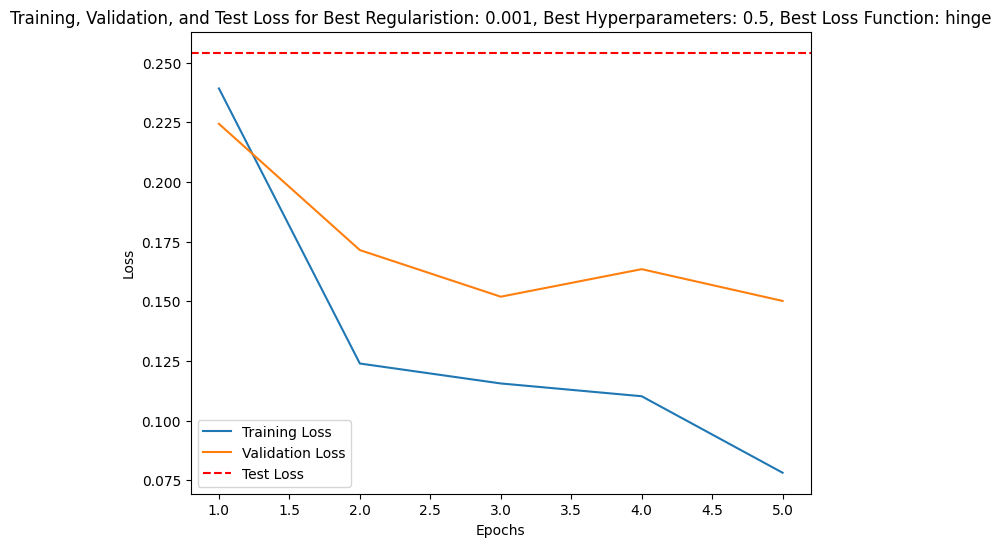

In [ ]:
# Find the index of the best hyperparameters
best_index = None
for i in range(len(train_losses)):
    if reg_strengths[i] == best_reg_strength and emphasis_factors[i] == best_emphasis and loss_functions[i] == best_loss_function:
        best_index = i
        break

if best_index is not None:
    # Plot the training, validation, and test loss for the best hyperparameters
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses[best_index]) + 1), train_losses[best_index], label='Training Loss')
    plt.plot(range(1, len(val_losses[best_index]) + 1), val_losses[best_index], label='Validation Loss')
    plt.axhline(final_test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training, Validation, and Test Loss for Best Regularistion: {best_reg_strength}, Best Hyperparameters: {best_emphasis}, Best Loss Function: {best_loss_function}')
    plt.show()
else:
    print("Best hyperparameters not found in the recorded losses.")
